In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import pandas as pd
import numpy as np

import sklearn
import sklearn.model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [4]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

In [5]:
X_train_all = train_df.loc[:, train_df.columns != "label"].values.reshape((-1, 28, 28)) / 255
y_train_all = train_df['label'].values
X_test = test_df.loc[:, test_df.columns != "label"].values.reshape((-1, 28, 28)) / 255

print('X_train_all.shape: {}'.format(X_train_all.shape))
print('X_train_all.__class__: {}'.format(X_train_all.__class__))
print('y_train_all.shape: {}'.format(y_train_all.shape))
print('y_train_all.__class__: {}'.format(y_train_all.__class__))
print('X_test.shape: {}'.format(X_test.shape))
print('X_test.__class__: {}'.format(X_test.__class__))

X_train_all.shape: (42000, 28, 28)
X_train_all.__class__: <class 'numpy.ndarray'>
y_train_all.shape: (42000,)
y_train_all.__class__: <class 'numpy.ndarray'>
X_test.shape: (28000, 28, 28)
X_test.__class__: <class 'numpy.ndarray'>


In [6]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X_train_all,
    y_train_all,
    test_size=0.1,
    shuffle=True,
    stratify=y_train_all,
    random_state=79508,
)

print('X_train.shape: {}'.format(X_train.shape))
print('X_val.shape: {}'.format(X_val.shape))
print('y_train.shape: {}'.format(y_train.shape))
print('y_val.shape: {}'.format(y_val.shape))

X_train.shape: (37800, 28, 28)
X_val.shape: (4200, 28, 28)
y_train.shape: (37800,)
y_val.shape: (4200,)


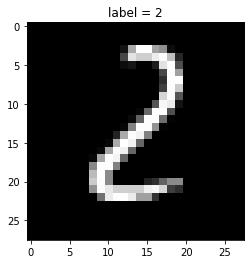

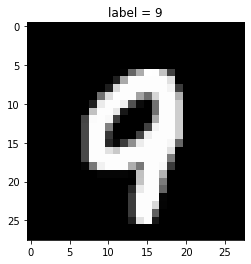

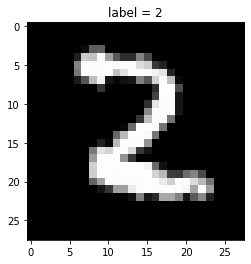

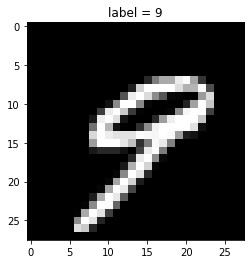

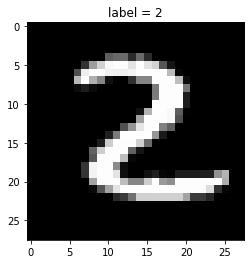

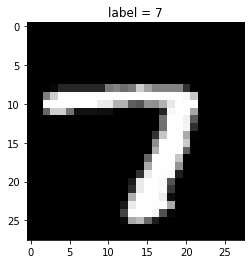

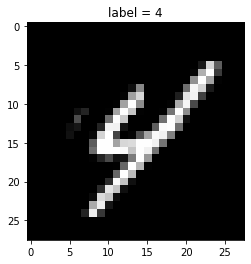

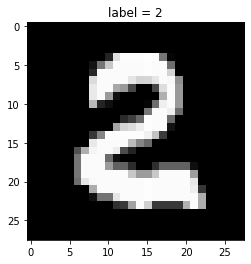

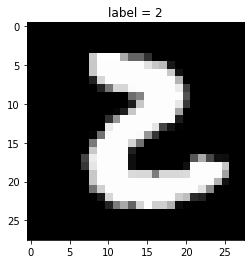

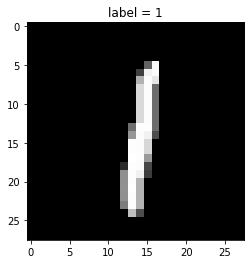

In [10]:
for i in range(10):
    plt.imshow(X_train[i], cmap='gray')
    plt.title('label = {}'.format(y_train[i]))
    plt.show()

In [11]:
y_unq = np.unique(y_train_all)
y_unq

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [12]:
import torch.optim as optim
from torchvision import datasets, transforms

In [13]:
from collections import defaultdict
import time

In [14]:
class Net(nn.Module):
    def __init__(self, activation_fn=None, n_targets=10):
        super(Net, self).__init__()
        if activation_fn is None:
            self.activation_fn = F.relu
        else:
            self.activation_fn = activation_fn
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, n_targets)

    def forward(self, x):
        x = self.activation_fn(F.max_pool2d(self.conv1(x), 2))
        x = self.activation_fn(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.activation_fn(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

In [15]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    train_log = defaultdict(list)
    t_log = time.time()
    n_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        t0 = time.time()
        data, target = data.to(device), target.to(device).long()
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        t1 = time.time()
        loss.backward()
        t2 = time.time()
        optimizer.step()
        t3 = time.time()
        n_samples += data.shape[0]
        if batch_idx % log_interval == 0:
            pred = output.max(1, keepdim=True)[1]
            correct = pred.eq(target.view_as(pred)).sum().item()

            train_log['n_iter'].append(epoch * len(train_loader) + batch_idx + 1)
            train_log['n_samples'].append(n_samples + (epoch - 1) * len(train_loader.dataset))
            train_log['loss'].append(loss.detach())
            train_log['accuracy'].append(100. * correct / data.shape[0])
            train_log['time_batch'].append(t3 - t0)
            train_log['time_batch_forward'].append(t1 - t0)
            train_log['time_batch_backward'].append(t2 - t1)
            train_log['time_batch_update'].append(t3 - t2)
            t4 = time.time()
            train_log['time_batch_avg'].append((t4 - t_log) / log_interval)
            print(
                'Train Epoch: {} [{:5d}/{:5d} ({:3.0f}%)]'
                '\tLoss: {:.6f}'
                '\tTime: {:.4f}ms/batch'.format(
                    epoch, n_samples, len(train_loader.dataset),
                    100. * (batch_idx + 1) / len(train_loader), loss.item(),
                    1000 * (t4 - t_log) / log_interval,
                )
            )
            t_log = time.time()
    return train_log

def test(model, device, test_loader, log_interval):
    model.eval()
    test_loss = 0
    correct = 0
    preds = []
    targets = []
    num_batches = 0
    with torch.no_grad():
        for data, target in test_loader:
            num_batches += 1
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            preds.append(pred.cpu().numpy())
            targets.append(target.cpu().numpy())
    
    # Remove list nesting
    preds = np.concatenate(preds).squeeze()
    targets = np.concatenate(targets).squeeze()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'
        ''.format(
            test_loss,
            correct, len(test_loader.dataset), accuracy,
            )
        )
    return test_loss, accuracy

def main(
        batch_size=64,
        test_batch_size=None,
        n_epoch=10,
        lr=0.01,
        momentum=0.5,
        no_cuda=False,
        seed=1,
        net=Net,
        activation_fn=F.relu,
        n_targets=10,
        log_interval=10,
        ):

    if test_batch_size is None:
        test_batch_size = batch_size

    use_cuda = not no_cuda and torch.cuda.is_available()

    # For reproducible models
    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    # Simple data loader, without augmentations
    # Note that we have a call to expand_dims.
    # This is to insert the channel dimension. Conv2D uses NCHW ordering.
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.Tensor(np.expand_dims(X_train, axis=1)).float(),
            torch.Tensor(y_train).long(),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.Tensor(np.expand_dims(X_val, axis=1)).float(),
            torch.Tensor(y_val).long(),
        ),
        batch_size=batch_size,
        shuffle=True,
    )

    model = net(activation_fn=activation_fn, n_targets=n_targets).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    train_log = defaultdict(list)
    val_log = defaultdict(list)

    for epoch in range(1, n_epoch + 1):
        epoch_log = train(model, device, train_loader, optimizer, epoch, log_interval)
        for key, value in epoch_log.items():
            train_log[key] += value
        
        val_loss, val_accuracy = test(model, device, val_loader, log_interval)
        val_log['loss'].append(val_loss)
        val_log['accuracy'].append(val_accuracy)
    
    return model, train_log, val_log

In [16]:
def collapse_nested_list(l):
    return [a for b in l for a in b]

def plot_training_log(train_log, val_log):
    #xx_train = np.arange(0, len(train_log['loss']), 1 / len(train_log['loss'][0]))
    xx_train = np.array(train_log['n_samples']) / 1000
    n_epoch = len(val_log['loss'])
    xx_val = np.arange(1, n_epoch + 1) * xx_train[-1] / n_epoch
    
    plt.plot(xx_train, train_log['loss'], 'b')
    # We prepend the first train loss score so there are enough datapoints to plot
    # a line, even with a single epoch.
    plt.plot(np.concatenate([[0], xx_val]), [train_log['loss'][0]] + val_log['loss'], 'ro-')
    plt.title('Loss (lower is better)')
    plt.xlabel('Number of samples presented (1000s)')
    plt.ylabel('Cross-Entropy Loss')
    plt.show()
    
    plt.plot(xx_train, train_log['accuracy'], 'b')
    plt.plot(np.concatenate([[0], xx_val]), [train_log['accuracy'][0]] + val_log['accuracy'], 'ro-')
    plt.title('Accuracy (higher is better)')
    plt.xlabel('Number of samples presented (1000s)')
    plt.ylabel('Accuracy (%)')
    plt.show()
    
    if n_epoch > 1:
        plt.plot(xx_train, train_log['accuracy'], 'b')
        plt.plot(np.concatenate([[0], xx_val]), [10] + val_log['accuracy'], 'ro-')
        plt.ylim([90, 100])
        plt.title('Accuracy, zoomed in')
        plt.xlabel('Number of samples presented (1000s)')
        plt.ylabel('Accuracy (%)')
        plt.show()
    
    plt.plot(xx_train, 1000 * np.array(train_log['time_batch_avg']), 'b')
    plt.title('Training speed (lower is better)')
    plt.xlabel('Number of samples presented (1000s)')
    plt.ylabel('Duration per batch (ms)')
    plt.show()

Train Epoch: 1 [   64/37800 (  0%)]	Loss: 2.308682	Time: 190.6000ms/batch
Train Epoch: 1 [  704/37800 (  2%)]	Loss: 2.308407	Time: 2.3000ms/batch
Train Epoch: 1 [ 1344/37800 (  4%)]	Loss: 2.302007	Time: 2.0999ms/batch
Train Epoch: 1 [ 1984/37800 (  5%)]	Loss: 2.309113	Time: 2.2000ms/batch
Train Epoch: 1 [ 2624/37800 (  7%)]	Loss: 2.296553	Time: 2.1000ms/batch
Train Epoch: 1 [ 3264/37800 (  9%)]	Loss: 2.306046	Time: 2.1001ms/batch
Train Epoch: 1 [ 3904/37800 ( 10%)]	Loss: 2.290441	Time: 2.0999ms/batch
Train Epoch: 1 [ 4544/37800 ( 12%)]	Loss: 2.292404	Time: 2.1000ms/batch
Train Epoch: 1 [ 5184/37800 ( 14%)]	Loss: 2.303139	Time: 2.1000ms/batch
Train Epoch: 1 [ 5824/37800 ( 15%)]	Loss: 2.298324	Time: 2.2000ms/batch
Train Epoch: 1 [ 6464/37800 ( 17%)]	Loss: 2.278966	Time: 2.3000ms/batch
Train Epoch: 1 [ 7104/37800 ( 19%)]	Loss: 2.279695	Time: 2.1000ms/batch
Train Epoch: 1 [ 7744/37800 ( 20%)]	Loss: 2.263306	Time: 2.1999ms/batch
Train Epoch: 1 [ 8384/37800 ( 22%)]	Loss: 2.282403	Time: 2.100

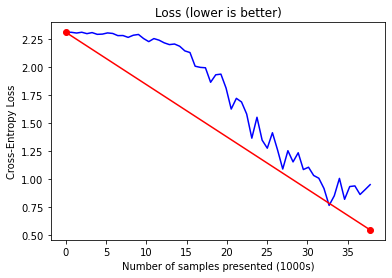

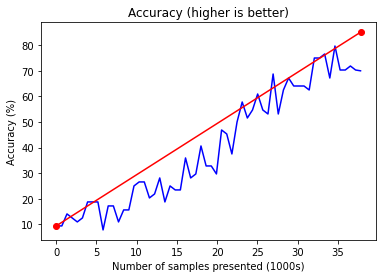

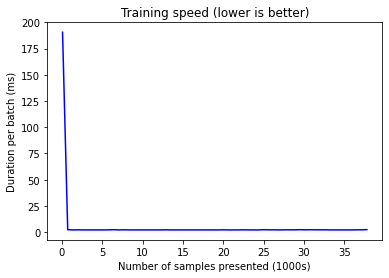

In [17]:
# Check we can train a single epoch on GPU
t0 = time.time()
model, train_log, val_log = main(no_cuda=False, n_epoch=1)
t1 = time.time()
print('Training completed in {} seconds.'.format(t1 - t0))
plot_training_log(train_log, val_log)

Train Epoch: 1 [   64/37800 (  0%)]	Loss: 2.309907	Time: 1.4001ms/batch
Train Epoch: 1 [  704/37800 (  2%)]	Loss: 2.320724	Time: 7.6999ms/batch
Train Epoch: 1 [ 1344/37800 (  4%)]	Loss: 2.297282	Time: 7.3000ms/batch
Train Epoch: 1 [ 1984/37800 (  5%)]	Loss: 2.300997	Time: 7.2001ms/batch
Train Epoch: 1 [ 2624/37800 (  7%)]	Loss: 2.303262	Time: 8.4000ms/batch
Train Epoch: 1 [ 3264/37800 (  9%)]	Loss: 2.296737	Time: 7.9000ms/batch
Train Epoch: 1 [ 3904/37800 ( 10%)]	Loss: 2.294386	Time: 7.4003ms/batch
Train Epoch: 1 [ 4544/37800 ( 12%)]	Loss: 2.298560	Time: 7.4998ms/batch
Train Epoch: 1 [ 5184/37800 ( 14%)]	Loss: 2.300241	Time: 7.3000ms/batch
Train Epoch: 1 [ 5824/37800 ( 15%)]	Loss: 2.294909	Time: 7.9000ms/batch
Train Epoch: 1 [ 6464/37800 ( 17%)]	Loss: 2.280067	Time: 7.3001ms/batch
Train Epoch: 1 [ 7104/37800 ( 19%)]	Loss: 2.289428	Time: 7.2002ms/batch
Train Epoch: 1 [ 7744/37800 ( 20%)]	Loss: 2.277273	Time: 7.1998ms/batch
Train Epoch: 1 [ 8384/37800 ( 22%)]	Loss: 2.273772	Time: 7.4000m

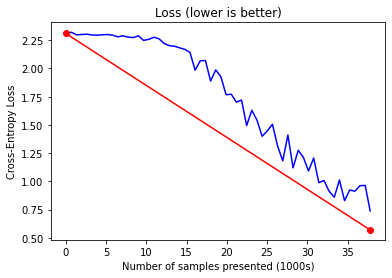

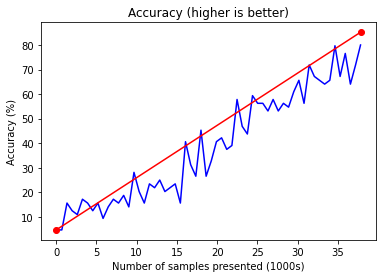

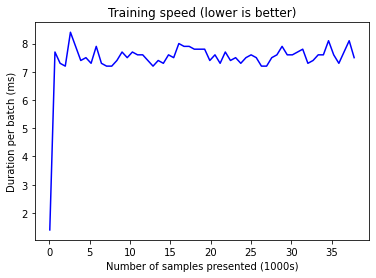

In [18]:
# Try on CPU to compare compute time
t0 = time.time()
model, train_log, val_log = main(no_cuda=True, n_epoch=1)
t1 = time.time()
print('Training completed in {} seconds.'.format(t1 - t0))
plot_training_log(train_log, val_log)

Train Epoch: 1 [   64/37800 (  0%)]	Loss: 2.308682	Time: 0.5002ms/batch
Train Epoch: 1 [  704/37800 (  2%)]	Loss: 2.308407	Time: 7.4996ms/batch
Train Epoch: 1 [ 1344/37800 (  4%)]	Loss: 2.302007	Time: 2.0000ms/batch
Train Epoch: 1 [ 1984/37800 (  5%)]	Loss: 2.309113	Time: 2.0000ms/batch
Train Epoch: 1 [ 2624/37800 (  7%)]	Loss: 2.296553	Time: 2.2003ms/batch
Train Epoch: 1 [ 3264/37800 (  9%)]	Loss: 2.306046	Time: 2.1996ms/batch
Train Epoch: 1 [ 3904/37800 ( 10%)]	Loss: 2.290441	Time: 2.1003ms/batch
Train Epoch: 1 [ 4544/37800 ( 12%)]	Loss: 2.292404	Time: 2.2001ms/batch
Train Epoch: 1 [ 5184/37800 ( 14%)]	Loss: 2.303139	Time: 2.1997ms/batch
Train Epoch: 1 [ 5824/37800 ( 15%)]	Loss: 2.298324	Time: 2.2005ms/batch
Train Epoch: 1 [ 6464/37800 ( 17%)]	Loss: 2.278966	Time: 2.2000ms/batch
Train Epoch: 1 [ 7104/37800 ( 19%)]	Loss: 2.279695	Time: 2.0996ms/batch
Train Epoch: 1 [ 7744/37800 ( 20%)]	Loss: 2.263306	Time: 2.1000ms/batch
Train Epoch: 1 [ 8384/37800 ( 22%)]	Loss: 2.282402	Time: 2.2003m

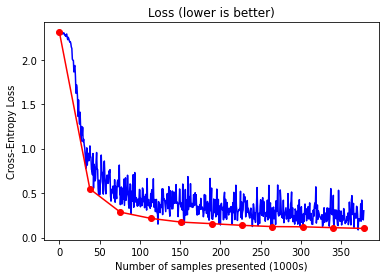

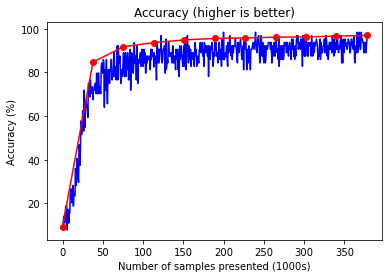

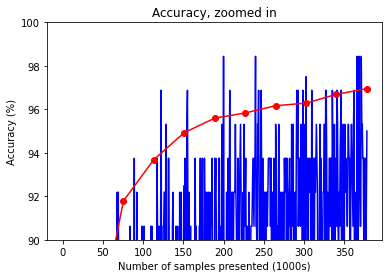

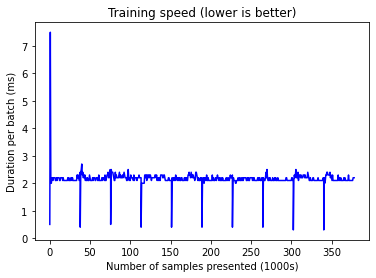

In [19]:
# Train model for 10 epochs
t0 = time.time()
model, train_log, val_log = main(n_epoch=10)
t1 = time.time()
print('Training completed in {} seconds.'.format(t1 - t0))
plot_training_log(train_log, val_log)

Source: https://www.kaggle.com/scottclowe/testing-gpu-enabled-notebooks-mnist-pytorch